All these examples are from Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

In [1]:
using Random
using Distributions
using Plots

# 1. Metropolis Hasting

The following example is an implementation of MH for sampling from a mixture of two 1D Gaussians. Example from section 24.3.3.

In [17]:
function unnormalized_mixture_1D_normal(x, π, μ, Σ)
    """
    Unnormalized mixture of two 1D gaussians
    Inputs
        x: float,
            sample
        π: array, size(π) = (2,)
            mixing weigths
        μ: array, size(μ) = (2,)
            array with the mean of each mixture
        Σ: array, size(Σ) = (2,)
            array with the variance of each mixture
    Output
        p(x|π, μ, Σ): float,
            pdf of x given π, μ, Σ, assume that x come from 
            a mixture of two 1D gaussians
    """
    pdf1 =  pdf(Normal(μ[1], Σ[1]^(1/2)), x)
    pdf2 =  pdf(Normal(μ[2], Σ[2]^(1/2)), x) 
    return π[1]*pdf1+π[2]*pdf2
end    

function proposal(x, μ, σ)
    """
    Evaluate pdf from a gaussian random walk proposal
    Inputs
        x: float
            sample
        μ: float
            mean
        σ: float
            standard deviation, is an hiperparameter in MH
    Output
        q(x|μ, σ): float
            pdf of x given μ, σ, assume that x come from
            a 1D gaussian
    """
    pdf(Normal(μ, σ), x) 
end

function sampling_from_proposal(μ, σ)
    """
    Sampling from a gaussian random walk proposal
    Inputs
        μ: float
            mean
        σ: float
            standard deviation, is an hyperparameter in MH
    Output
        x: float
            sample from Normal(μ, σ)
    """
   x = rand(Normal(μ, σ), 1)[1]
end 

sampling_from_proposal (generic function with 1 method)

In [20]:
function metropolis_mixture_1D_normal(σ, π, μ, Σ, n_iter, seed=0)
    """
    Metropolis Hasting algorithm from mixture of two 1D gaussians
    Inputs
        σ: float
            standard deviation, proposal hyperparameter
        π: array, size(π) = (2,)
            mixing weigths
        μ: array, size(μ) = (2,)
            array with the mean of each mixture
        Σ: array, size(Σ) = (2,)
            array with the variance of each mixture
        n_iter: int,
            number of iterations
        seed: int, default 0
            random seed
    Output
        trace: array, size(trace) = (n_iter, )
            samples generated by MH
        accepted_rate: float,
            rate of samples accepted
    """
    # initialize
    Random.seed!(seed)
    x_old = 0.0
    trace = [x_old]
    accepted = 0.0
    # chain iterations
    for i in 2:n_iter
        # sampling from proposal
        x_new = sampling_from_proposal(x_old, σ) 
        # compute acceptance probability
        α = unnormalized_mixture_1D_normal(x_new, π, μ, Σ)* proposal(x_old, x_new, σ)/(unnormalized_mixture_1D_normal(x_old, π, μ, Σ)*proposal(x_new, x_old, σ))
        r = min(1, α)
        u = rand(Uniform(0,1),1)[1]
        if r > u
            x_old = x_new
            accepted+=1
        end
        # update trace
        push!(trace, x_old)
    end
    accepted_rate = accepted/n_iter
    return trace, accepted_rate
end

metropolis_mixture_1D_normal (generic function with 2 methods)

In [21]:
μ = [-20, 20] 
Π = [0.3, 0.7] 
Σ = [100, 100] 
σ = 8.0
n_iter = 1000000
seed = 1
@time trace, accepted_rate = metropolis_mixture_1D_normal(σ, Π, μ, Σ, n_iter, seed)
accepted_rate

  0.321668 seconds (2.14 M allocations: 199.517 MiB, 5.03% gc time)


0.792813

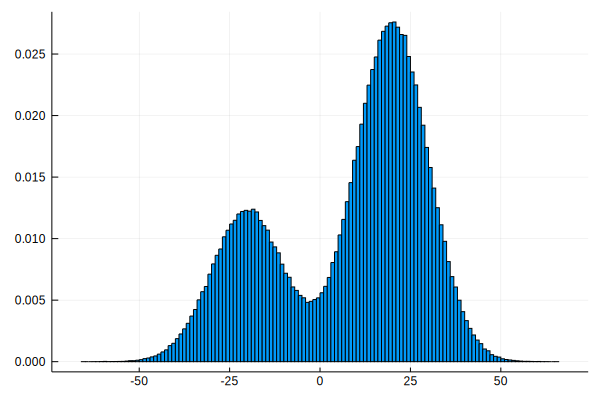

In [22]:
histogram(trace, leg = false, normalize=true)

# 2. Gibbs Sampling

## 2.1 Gibbs Sampling from a 2D Gaussian

Exercise 24.1.

In [23]:
function fullconditional(x, i, μ, Σ)
    """
    Full conditional distribution from a 2D gaussian
    Inputs
        x: array, size(x) = (2,)
            a 2D sample
        i: int
            sample index where to get the full conditional
        μ: array, size(μ) = (2,)
            means vector
        Σ: array, size(Σ) = (2,2)
            covariance matrix
    Output
        p(x[i]|x[-i], μ, Σ): 1D Normal distribution
            full conditional distribution from x[i]
    """
    if i == 1
        mu = μ[1]+Σ[1,2]*(x-μ[2])/Σ[2,2]
        variance = Σ[1,1]-Σ[1,2]^2/Σ[2,2]
    else
        mu = μ[2]+Σ[1,2]*(x-μ[1])/Σ[1,1]
        variance = Σ[2,2]-Σ[1,2]^2/Σ[1,1]
    end    
    return Normal(mu, variance^(1/2))
end

fullconditional (generic function with 1 method)

In [24]:
function gibbs_sampling_2DGaussian(μ, Σ, n_iter, seed=0)
    """
    Gibbs sampling from a 2D Gaussian
    Inputs
        μ array, size(μ) = (2,)
            means vector
        Σ: array, size(Σ) = (2,2)
            covariance matrix
        n_iter:  int
            number of iterations
        seed: int, default 0
            random seed
    Output:
        trace: array, size(trace) = (n_iter, 2)
            samples generated by gibbs sampling
    """
    # initialize
    Random.seed!(seed)
    x1 = 1.0
    x2 = 1.0
    trace = zeros((n_iter, 2))
    trace[1,:] = [x1, x2]
    # chain iteration
    for i in 2:n_iter
        # sampling x1 given x2
        x1 = rand(fullconditional(x2, 1, μ, Σ), 1)[1]
        # sampling x2 given x1
        x2 = rand(fullconditional(x1, 2, μ, Σ), 1)[1]
        # update trace
        trace[i,:] = [x1, x2]
    end
    return trace
end

gibbs_sampling_2DGaussian (generic function with 2 methods)

In [25]:
@userplot MarginalHist

@recipe function f(h::MarginalHist)
    if length(h.args) != 2 || !(typeof(h.args[1]) <: AbstractVector) ||
        !(typeof(h.args[2]) <: AbstractVector)
        error("Marginal Histograms should be given two vectors.  Got: $(typeof(h.args))")
    end
    x, y = h.args

    # set up the subplots
    legend := false
    link := :both
    framestyle := [:none :axes :none]
    grid := false
    layout := @layout [tophist           _
                       hist2d{0.9w,0.9h} righthist]

    # main histogram2d
    @series begin
        seriestype := :histogram2d
        subplot := 2
        x, y
    end

    # these are common to both marginal histograms
    fillcolor := :blue
    fillalpha := 0.8
    linealpha := 0.3
    seriestype := :histogram

    # upper histogram
    @series begin
        subplot := 1
        x
    end

    # right histogram
    @series begin
        orientation := :h
        subplot := 3
        y
    end
end

In [26]:
μ = [1,1]
Σ = [[1, -0.5] [-0.5, 1]]
seed = 1
@time trace = gibbs_sampling_2DGaussian(μ, Σ, 1000000, seed);

  0.219425 seconds (3.10 M allocations: 295.369 MiB, 9.69% gc time)


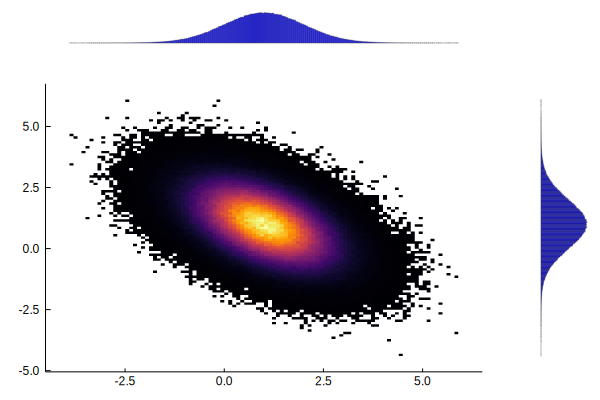

In [27]:
marginalhist(trace[:,1], trace[:,2], normalize=true)

## 2.2 Gibbs sampling for a 1D Gaussian mixture model

Exercise 24.2.

In [28]:
function z_full_conditional(x_i, μ, Σ, π)
    """
    Full conditional distribution from hidden variable z_i,
    Inputs
        Model variables
            x_i: float, 
                observation
            μ: array, length(μ)= K
                array with the mean of each cluster, 
            π: array, length(π) = K
                mixing weights
            Σ: array, length(Σ)= K
                array with the variance of each cluster, 
                K: number of clusters
    Output
        p(z_i|x_i, μ, Σ, π): Categorial distribution,
            full conditional distribution from z_i
    """
    # get probability vector
    K = length(π)
    p = zeros(K)
    for k in 1:K
        p[k] = π[k]*pdf(Normal(μ[k], Σ[k]^(1/2)), x_i) 
    end
    # p must sum 1
    p = p/sum(p)
    # return multinomal distributino for sampling z_i
    return Categorical(p)
end

function π_full_conditional(z, α)
    """
    Full conditiona distribution from mixing weights π
    Inputs
        Dirichlet Prior parameter from π:
            alpha: array, length(α) = K
        Model variables
            z: array, length(z) = N
                hiddens variables, array with cluster assignments, 
                N: number of observations
    Output
        p(π|z) = Dirichlet distribution,
            full conditional distribution from π
    """
    # update prior parameters (α) 
    N = length(z)
    K = length(α)
    for k in 1:K
        for i in 1:N
            if z[i] == k
                α[k]+=1
            end
        end
    end
    # return dirichlet distributino for sampling π
    return Dirichlet(α)
end

function μ_full_conditional(k, Σ, z, x, m_0, V_0)
    """
    Full conditional distribution from means μ_k
    Inputs
        Gaussian Prior parameters from μ_k:
            m_0: float, 
                    mean
            V_0: float, 
                    variance
        Model variables
            k: int,
                cluster assignment
            Σ: array, length(Σ)= K
                array with the variance of each cluster, 
                K: number of clusters
            z: array, length(z) = N
                hiddens variables, array with cluster assignments, 
                N: number of observations
            x: array, length(x) = N
                observations
    Output
        p(μ_k|Σ_k, z, x): 1D Normal distribution,
            full conditional distribution from μ_k
    """
    # update prior parameters
    N = length(z)
    N_k = sum([if z[i]==k 1 else 0 end for i in 1:N])
    x_k = sum([if z[i]==k x[i] else 0 end for i in 1:N])/N_k
    V_k = V_0*Σ[k]/(Σ[k]+N_k*V_0)
    m_k = V_k*(N_k*x_k/Σ[k]+m_0/V_0)
    # return 1d gaussian distributino for sampling μ_k
    return Normal(m_k, V_k^(1/2))
end

function Σ_full_conditional(k, μ, z, x, v_0, S_0)
    """
    Full conditional distribution from variance Σ_k
    Inputs
        Inverse-Wishart parameters from Σ_k (inverse gamma distributino in 1D):
            v_0: float, 
                    shape parameter
            S_0: float, 
                    scale parameter
        Model variables
            k: int,
                cluster assignment
            μ: array, length(μ)= K
                array with the mean of each cluster, 
                K: number of clusters
            z: array, length(z) = N
                hiddens variables, array with cluster assignments, 
                N: number of observations
            x: array, length(x) = N
                observations
    Output
        p(Σ_k|μ_k, z, x): InverseGamma distribution,
            full conditional distribution from Σ_k
    """
    # update prior parameters
    N = length(z)
    N_k = sum([if z[i]==k 1 else 0 end for i in 1:N])
    S_k = S_0 + sum([if z[i]==k 1*(x[i]-μ[k])^2 else 0 end for i in 1:N ])
    v_k = v_0 + N_k
     # return gamma distributino for sampling Σ_k
    return InverseGamma(v_k/2,  S_k/2)
end


Σ_full_conditional (generic function with 1 method)

In [29]:
function gibbs_sampling_1DGMM(x, α, m_0, V_0, v_0, S_0, n_iter, seed = 0)
    """
    Gibbs from a 1D Gaussian Mixture Model
    Inputs
        Prior parameters
            α: array, length(K)
                 parameter of dirichlet prior from π, K: number of cluster to find
            m_0: float
                mean of gaussian prior from μ_k
            V_0: float
                variance of gaussian prior from μ_k
            v_0: float
                shape parameter from inverse gamma prior from Σ_k
            S_0: float
                scale parameter from inverse gamma prior from Σ_k
        Model parameters
            x: array, length(x) = N
                samples
            n_iter: int
                number of iterations
            seed: int, default 0
                random seed
    Output
        trace: Dict, 
            dictionary with the trace of each variable,
                π: array, size(π) = (n_iter, K)
                    mixing weights
                z: array, size(z) = (n_iter, N)
                    cluster assignments
                μ: array, size(μ) = (n_iter, K)
                    means 
                Σ: array, size(Σ) = (n_iter, K)
                    variances
    """
    # initialize
    Random.seed!(seed)
    N = length(x)
    K = length(α)
    π = rand(Dirichlet(α), 1)
    z = rand(Categorical(reshape(π, (K,))), N)
    μ = rand(Normal(m_0, V_0^(1/2)), K)
    Σ = rand(InverseGamma(v_0/2, S_0/2), K)    

    trace = Dict("π"=>zeros((n_iter, K)), "z"=>zeros((n_iter, N)), 
                 "μ"=>zeros((n_iter, K)), "Σ"=>zeros((n_iter, K)))
    trace["π"][1,:] = π
    trace["z"][1,:] = z
    trace["μ"][1,:] = μ
    trace["Σ"][1,:] = Σ
    
    for i in 2:n_iter
       
        # sampling hidden variables
        for j in 1:N
           z[j] = rand(z_full_conditional(x[j], μ, Σ, π), 1)[1] 
        end

        # sampling mixing weights
        π = rand(π_full_conditional(z, α), 1)

        # sampling means
        for k in 1:K    
            μ[k] = rand(μ_full_conditional(k, Σ, z, x, m_0, V_0), 1)[1]
        end

        # sampling variances
        for k in 1:K
            Σ[k] =  rand(Σ_full_conditional(k, μ, z, x, v_0, S_0), 1)[1]
        end
        
        # update trace
        trace["π"][i,:] = π
        trace["z"][i,:] = z
        trace["μ"][i,:] = μ
        trace["Σ"][i,:] = Σ
    end
    return trace
end

gibbs_sampling_1DGMM (generic function with 2 methods)

In [33]:
μ = [-20, 20] 
Π = [0.3, 0.7] 
Σ = [100, 100] 
σ = 8.0
n_iter = 100000
seed = 1
@time x, accepted_rate = metropolis_mixture_1D_normal(σ, Π, μ, Σ, n_iter, seed);

  0.030485 seconds (200.03 k allocations: 20.312 MiB)


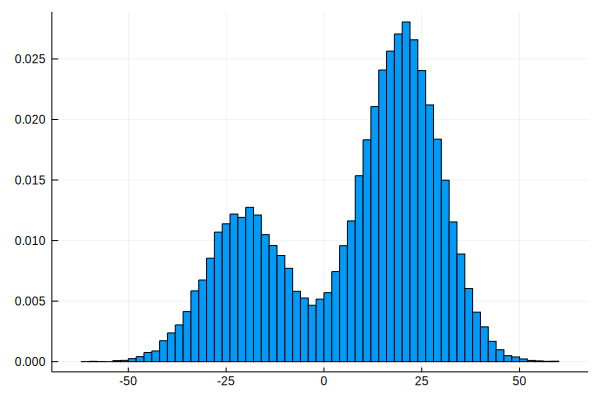

In [34]:
histogram(x, leg = false, normalize=true)

In [88]:
α = [1, 1]
m_0 = 0
V_0 = 100
v_0 = 100
S_0 = 10000
n_iter = 10000
seed = 10;
@time trace = gibbs_sampling_1DGMM(x, α, m_0, V_0, v_0, S_0, n_iter, seed);

597.078402 seconds (15.87 G allocations: 988.940 GiB, 17.92% gc time)


In [89]:
# discard first half of the trace and get posterior mean
half = Int(ceil(n_iter/2))
Σ_1 = mean(trace["Σ"][end-half, 1])
Σ_2 = mean(trace["Σ"][end-half, 2])
μ_1 = mean(trace["μ"][end-half, 1])
μ_2 = mean(trace["μ"][end-half, 2])
π_1 = mean(trace["π"][end-half, 1])
π_2 = mean(trace["π"][end-half, 2])

Σ = [Σ_1, Σ_2]
μ = [μ_1, μ_2]
Π = [π_1, π_2]

println("Σ: $(Σ)")
println("π: $(Π)")
println("μ: $(μ)")

Σ: [105.2180060968878, 96.50270632643608]
π: [0.32039685423732783, 0.6796031457626721]
μ: [-20.178922936916162, 19.959955662265898]


In [90]:
# sampling from 1D GMM with K=2
σ = 8 
n_iter = 1000000
seed = 1
@time trace, accepted_rate = metropolis_mixture_1D_normal(σ, Π, μ, Σ, n_iter, seed);

  0.309518 seconds (2.16 M allocations: 200.786 MiB, 6.32% gc time)


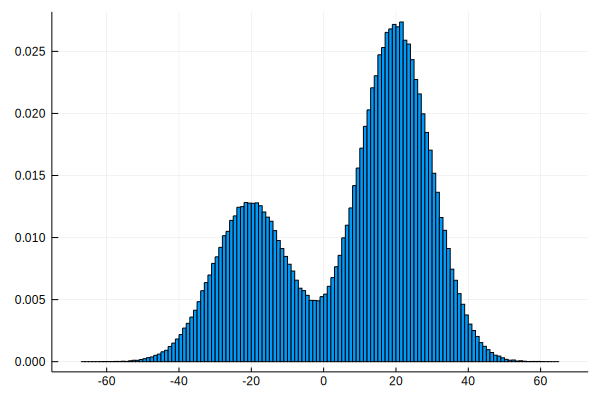

In [91]:
histogram(trace, leg = false, normalize=true)